# DMML Project: Laptop Price Regression

In [59]:
# Imports
import os
import re
import smogn
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import wilcoxon
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Dataset Inspection

In [60]:
# Load the dataset
laptop_df = pd.read_csv(os.path.join('dataset','laptopData.csv'))

In [61]:
# Check initial number of tuples and number of features
laptop_df.shape

(1303, 12)

In [62]:
laptop_df

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1.0,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2.0,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3.0,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080
...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1298.0,Lenovo,2 in 1 Convertible,14,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,33992.6400
1299,1299.0,Lenovo,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,79866.7200
1300,1300.0,Lenovo,Notebook,14,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,12201.1200
1301,1301.0,HP,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,40705.9200


# Data Preprocessing

In [63]:
# Start by removing the ID, as it's useless for the purpose
laptop_df = laptop_df.drop(['Unnamed: 0'], axis = 1)

In [64]:
# Check missing values
laptop_df.isna().sum()

Company             30
TypeName            30
Inches              30
ScreenResolution    30
Cpu                 30
Ram                 30
Memory              30
Gpu                 30
OpSys               30
Weight              30
Price               30
dtype: int64

In [65]:
# Null records are dropped as it appears null values were present only in completely null tuples
df_notna = laptop_df.dropna(how='any')
print(df_notna.isna().sum())

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64


In [66]:
# Fraction of tuples kept
len(df_notna)/len(laptop_df)

0.9769762087490407

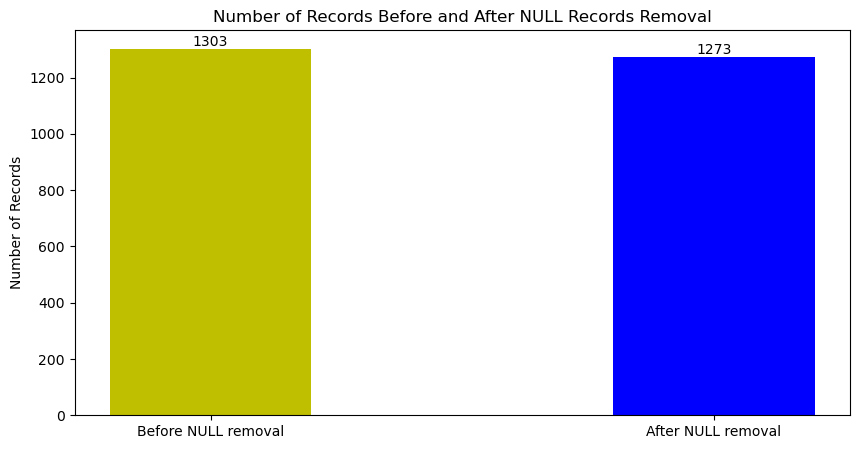

In [67]:
# Plotting the number of records before and after NULL removal
count_before = len(laptop_df)

count_after = len(df_notna)

# Plotting histogram of record counts
plt.figure(figsize=(10,5))
bars = plt.bar(['Before NULL removal', 'After NULL removal'], [count_before, count_after], color=['y', 'b'], width = 0.4)
plt.title('Number of Records Before and After NULL Records Removal')
plt.ylabel('Number of Records')

# Adding the values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    
plt.show()

In [68]:
# Verify the presence of eventual inconsistencies among features
df_notna.Company.unique()

array(['Apple', 'HP', 'Acer', 'Asus', 'Dell', 'Lenovo', 'Chuwi', 'MSI',
       'Microsoft', 'Toshiba', 'Huawei', 'Xiaomi', 'Vero', 'Razer',
       'Mediacom', 'Samsung', 'Google', 'Fujitsu', 'LG'], dtype=object)

In [69]:
df_notna.TypeName.unique()

array(['Ultrabook', 'Notebook', 'Gaming', '2 in 1 Convertible',
       'Workstation', 'Netbook'], dtype=object)

In [70]:
df_notna.Inches.unique()

array(['13.3', '15.6', '15.4', '14', '12', '17.3', '13.5', '12.5', '13',
       '18.4', '13.9', '11.6', '25.6', '35.6', '12.3', '27.3', '24',
       '33.5', '?', '31.6', '17', '15', '14.1', '11.3', '10.1'],
      dtype=object)

In [71]:
# '?' tuples need to be addressed
df_notna.Inches.value_counts()

Inches
15.6    640
14      192
17.3    162
13.3    161
12.5     38
11.6     31
12        6
13.9      6
13.5      5
12.3      5
15.4      4
15        4
35.6      3
10.1      3
24        2
13        2
18.4      1
27.3      1
33.5      1
?         1
31.6      1
17        1
14.1      1
11.3      1
25.6      1
Name: count, dtype: int64

In [72]:
# Since there is only one unkown value, the record is removed
df_notna = df_notna[df_notna['Inches'] != '?']

In [73]:
# Control the issue was solved
df_notna.Inches.value_counts()

Inches
15.6    640
14      192
17.3    162
13.3    161
12.5     38
11.6     31
12        6
13.9      6
13.5      5
12.3      5
15.4      4
15        4
35.6      3
10.1      3
24        2
13        2
18.4      1
27.3      1
33.5      1
31.6      1
17        1
14.1      1
11.3      1
25.6      1
Name: count, dtype: int64

In [74]:
df_notna.Weight.unique()

array(['1.37kg', '1.34kg', '1.86kg', '1.83kg', '2.1kg', '2.04kg', '1.3kg',
       '1.6kg', '2.2kg', '0.92kg', '1.22kg', '2.5kg', '1.62kg', '1.91kg',
       '2.3kg', '1.35kg', '1.88kg', '1.89kg', '1.65kg', '2.71kg', '1.2kg',
       '1.44kg', '2.8kg', '2kg', '2.65kg', '2.77kg', '3.2kg', '1.49kg',
       '2.4kg', '2.13kg', '2.43kg', '1.7kg', '1.4kg', '1.8kg', '1.9kg',
       '3kg', '1.252kg', '2.7kg', '2.02kg', '1.63kg', '1.96kg', '1.21kg',
       '2.45kg', '1.25kg', '1.5kg', '2.62kg', '1.38kg', '1.58kg',
       '1.85kg', '1.23kg', '2.16kg', '2.36kg', '7.2kg', '2.05kg',
       '1.32kg', '1.75kg', '0.97kg', '2.56kg', '1.48kg', '1.74kg',
       '1.1kg', '1.56kg', '2.03kg', '1.05kg', '5.4kg', '4.4kg', '1.90kg',
       '1.29kg', '2.0kg', '1.95kg', '2.06kg', '1.12kg', '3.49kg',
       '3.35kg', '2.23kg', '?', '2.9kg', '4.42kg', '2.69kg', '2.37kg',
       '4.7kg', '3.6kg', '2.08kg', '4.3kg', '1.68kg', '1.41kg', '4.14kg',
       '2.18kg', '2.24kg', '2.67kg', '4.1kg', '2.14kg', '1.36kg',
       '

In [75]:
df_notna.Weight.value_counts().get('?',0)

1

In [76]:
# Since there is only one uknown value, the record is dropped
df_notna = df_notna[df_notna['Weight'] != '?']

In [77]:
# The records with a weight under a certain treshold are dropped, as they are wrong or not laptops
df_notna['Weight'] = df_notna['Weight'].str.replace('kg', '').astype(float)
df_notna = df_notna[df_notna['Weight'] >= 0.3]

In [78]:
df_notna.ScreenResolution.unique()

array(['IPS Panel Retina Display 2560x1600', '1440x900',
       'Full HD 1920x1080', 'IPS Panel Retina Display 2880x1800',
       '1366x768', 'IPS Panel Full HD 1920x1080',
       'IPS Panel Retina Display 2304x1440',
       'IPS Panel Full HD / Touchscreen 1920x1080',
       'Full HD / Touchscreen 1920x1080',
       'Touchscreen / Quad HD+ 3200x1800', 'Touchscreen 2256x1504',
       'Quad HD+ / Touchscreen 3200x1800', 'IPS Panel 1366x768',
       'IPS Panel 4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Full HD 2160x1440',
       '4K Ultra HD / Touchscreen 3840x2160', '1600x900',
       'IPS Panel 4K Ultra HD 3840x2160', '4K Ultra HD 3840x2160',
       'Touchscreen 1366x768', 'Touchscreen 2560x1440',
       'IPS Panel Full HD 1366x768', 'IPS Panel 2560x1440',
       'IPS Panel Full HD 2560x1440',
       'IPS Panel Retina Display 2736x1824', 'Touchscreen 2400x1600',
       '2560x1440', 'IPS Panel Quad HD+ 2560x1440',
       'IPS Panel Quad HD+ 3200x1800',
       'IPS Panel Qua

In [79]:
# This time there are more inconsitencies
df_notna.ScreenResolution.value_counts()

ScreenResolution
Full HD 1920x1080                                492
1366x768                                         274
IPS Panel Full HD 1920x1080                      226
IPS Panel Full HD / Touchscreen 1920x1080         52
Full HD / Touchscreen 1920x1080                   45
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  14
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160                9
4K Ultra HD 3840x2160                              7
IPS Panel 1366x768                                 7
IPS Panel Retina Display 2560x1600                 6
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
Touchscreen 2560x1440                              6
IPS Panel Retina Display 2304x1440                 6
Touchscreen 2256x1504                              6
IPS Panel Touchscreen 2560x14

In [80]:
# The strategy adopted to solve this is to merge the values with the same resolution and to leave only the number
# Then the 2 dimensions are multiplied to get a single number
def extract_resolution(resolution):
    match = re.search(r'(\d+)x(\d+)', resolution)
    if match:
        width, height = map(int, match.groups())
        return width * height
    return np.nan

df_notna.loc[:, 'ScreenResolution'] = df_notna['ScreenResolution'].apply(extract_resolution)

In [81]:
# Control the issue was solved
df_notna.ScreenResolution.value_counts()

ScreenResolution
2073600    819
1049088    301
8294400     42
5760000     26
1440000     23
3686400     22
4096000      6
3317760      6
3393024      6
1296000      4
5184000      4
3840000      4
2304000      4
3110400      2
4990464      1
Name: count, dtype: int64

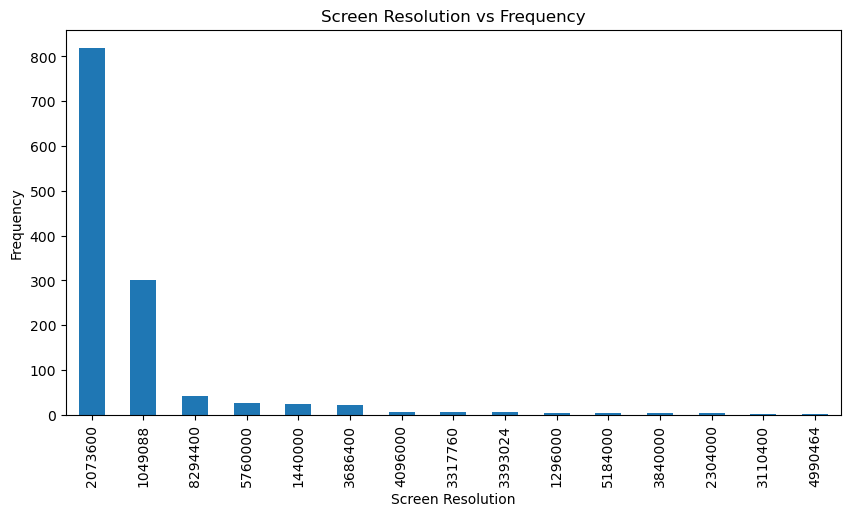

In [82]:
# Compute the frequency of each screen resolution
screen_res_freq = df_notna['ScreenResolution'].value_counts()

# Plotting bar plot of 'ScreenResolution' vs frequency
plt.figure(figsize=(10,5))
screen_res_freq.plot(kind='bar')
plt.title('Screen Resolution vs Frequency')
plt.xlabel('Screen Resolution')
plt.ylabel('Frequency')
plt.show()

In [83]:
df_notna.Cpu.unique()

array(['Intel Core i5 2.3GHz', 'Intel Core i5 1.8GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Core i7 2.7GHz',
       'Intel Core i5 3.1GHz', 'AMD A9-Series 9420 3GHz',
       'Intel Core i7 2.2GHz', 'Intel Core i7 8550U 1.8GHz',
       'Intel Core i5 8250U 1.6GHz', 'Intel Core i3 6006U 2GHz',
       'Intel Core i7 2.8GHz', 'Intel Core M m3 1.2GHz',
       'Intel Core i7 7500U 2.7GHz', 'Intel Core i7 2.9GHz',
       'Intel Core i3 7100U 2.4GHz', 'Intel Core i5 7300HQ 2.5GHz',
       'AMD E-Series E2-9000e 1.5GHz', 'Intel Core i5 1.6GHz',
       'Intel Core i7 8650U 1.9GHz', 'Intel Atom x5-Z8300 1.44GHz',
       'AMD E-Series E2-6110 1.5GHz', 'AMD A6-Series 9220 2.5GHz',
       'Intel Celeron Dual Core N3350 1.1GHz',
       'Intel Core i3 7130U 2.7GHz', 'Intel Core i7 7700HQ 2.8GHz',
       'Intel Core i5 2.0GHz', 'AMD Ryzen 1700 3GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Celeron Dual Core N3060 1.6GHz', 'Intel Core i5 1.3GHz',
       'AMD FX 9830P 3GHz', '

In [84]:
# Start by extracting the producer
df_notna = df_notna.copy()
df_notna['CpuProducer'] = df_notna['Cpu'].str.split().str[0]
df_notna.CpuProducer.value_counts()

CpuProducer
Intel      1207
AMD          62
Samsung       1
Name: count, dtype: int64

In [85]:
# Drop Samsung as there is only one and it's probably a mobile, so a wrong record
df_notna = df_notna[df_notna['CpuProducer'] != 'Samsung']

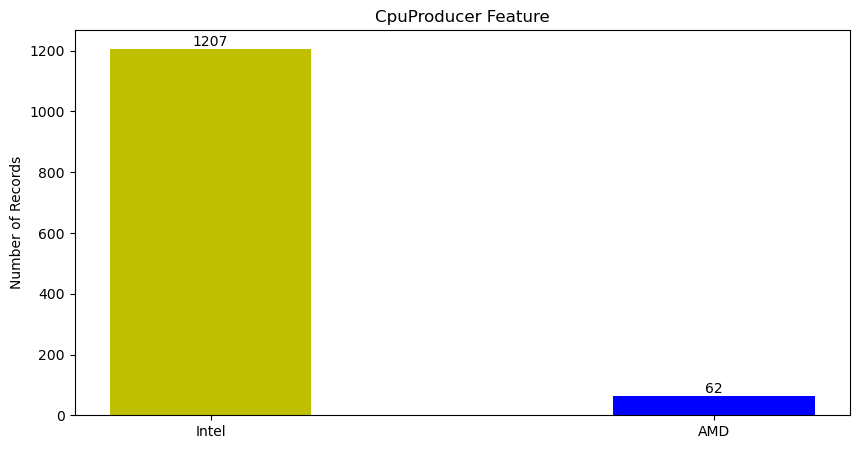

In [86]:
# Plotting the CpuProducer feature frequencies
cpu_producer_freq = df_notna['CpuProducer'].value_counts()

plt.figure(figsize=(10,5))
bars = plt.bar(cpu_producer_freq.index, cpu_producer_freq.values, color=['y', 'b'], width = 0.4)
plt.title('CpuProducer Feature')
plt.ylabel('Number of Records')

# Adding the values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    
plt.show()

In [87]:
# Now to extract the model
df_notna['CpuModel'] = df_notna['Cpu'].apply(lambda x: ' '.join(x.split()[1:-1]))
df_notna.CpuModel.unique()

array(['Core i5', 'Core i5 7200U', 'Core i7', 'A9-Series 9420',
       'Core i7 8550U', 'Core i5 8250U', 'Core i3 6006U', 'Core M m3',
       'Core i7 7500U', 'Core i3 7100U', 'Core i5 7300HQ',
       'E-Series E2-9000e', 'Core i7 8650U', 'Atom x5-Z8300',
       'E-Series E2-6110', 'A6-Series 9220', 'Celeron Dual Core N3350',
       'Core i3 7130U', 'Core i7 7700HQ', 'Ryzen 1700',
       'Pentium Quad Core N4200', 'Celeron Dual Core N3060', 'FX 9830P',
       'Core i7 7560U', 'E-Series 6110', 'Core i5 6200U', 'Core M 6Y75',
       'Core i5 7500U', 'Core i7 6920HQ', 'Core i5 7Y54',
       'Core i7 7820HK', 'Xeon E3-1505M V6', 'Core i7 6500U',
       'E-Series 9000e', 'A10-Series A10-9620P', 'A6-Series A6-9220',
       'Core i7 6600U', 'Celeron Dual Core 3205U', 'Core i7 7820HQ',
       'A10-Series 9600P', 'Core i7 7600U', 'A8-Series 7410',
       'Celeron Dual Core 3855U', 'Pentium Quad Core N3710',
       'A12-Series 9720P', 'Core i5 7300U', 'Celeron Quad Core N3450',
       'Core i5 6

In [88]:
# Given the model structure, define a function to standardize it as much as possible
def modify_model(row):
    model_words = row['CpuModel'].split()
    if row['CpuProducer'] == 'Intel':
        if model_words[0] == 'Core':
            return ' '.join(model_words[:2])
        else:
            return ' '.join(model_words[:3])
    elif row['CpuProducer'] == 'AMD':
        return model_words[0]
    else:
        return row['CpuModel']

df_notna['CpuModel'] = df_notna.apply(modify_model, axis=1)
df_notna.CpuModel.value_counts()

CpuModel
Core i7              513
Core i5              409
Core i3              134
Celeron Dual Core     79
Pentium Quad Core     27
Core M                19
A9-Series             17
A6-Series             11
E-Series               9
Celeron Quad Core      8
A12-Series             8
A10-Series             6
Ryzen                  4
Atom x5-Z8350          4
A8-Series              4
Pentium Dual Core      3
Atom x5-Z8550          3
FX                     2
Atom X5-Z8350          2
Xeon E3-1505M V6       2
Xeon E3-1535M v6       1
Atom Z8350             1
Xeon E3-1535M v5       1
Atom x5-Z8300          1
A4-Series              1
Name: count, dtype: int64

In [89]:
# Further standardization
def modify_model_2(row):
    model_words = row['CpuModel'].split()
    if model_words[0] in ['Xeon', 'Atom']:
        return model_words[0]
    else:
        return row['CpuModel']

df_notna['CpuModel'] = df_notna.apply(modify_model_2, axis=1)
df_notna.CpuModel.value_counts()

CpuModel
Core i7              513
Core i5              409
Core i3              134
Celeron Dual Core     79
Pentium Quad Core     27
Core M                19
A9-Series             17
Atom                  11
A6-Series             11
E-Series               9
Celeron Quad Core      8
A12-Series             8
A10-Series             6
A8-Series              4
Ryzen                  4
Xeon                   4
Pentium Dual Core      3
FX                     2
A4-Series              1
Name: count, dtype: int64

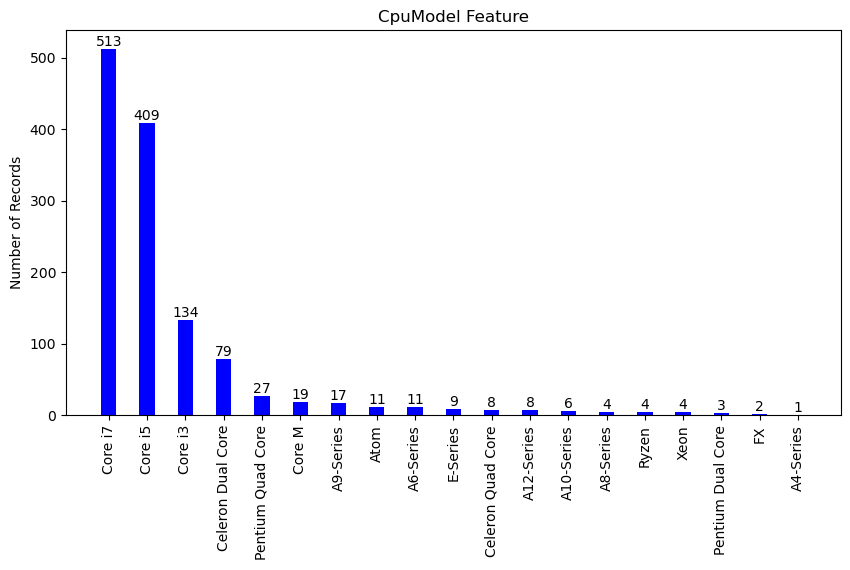

In [90]:
# Plotting the CpuModel feature frequencies
cpu_model_freq = df_notna['CpuModel'].value_counts()

plt.figure(figsize=(10,5))
bars = plt.bar(cpu_model_freq.index, cpu_model_freq.values, color=['b'], width = 0.4)
plt.title('CpuModel Feature')
plt.ylabel('Number of Records')
plt.xticks(rotation='vertical')

# Adding the values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    
plt.show()

In [91]:
# Finally, clock speed is extracted
df_notna['CpuClockSpeed'] = df_notna['Cpu'].str.split().str[-1].str.replace('GHz', '').astype(float)
df_notna.CpuClockSpeed.value_counts()

CpuClockSpeed
2.50    286
2.80    160
2.70    160
1.60    128
2.30     84
2.00     83
1.80     76
2.60     75
1.10     53
2.40     52
2.90     21
3.00     19
1.20     15
2.20     11
1.50     10
1.44     10
1.30      6
3.60      5
0.90      4
3.10      3
2.10      3
1.90      2
3.20      1
1.00      1
1.92      1
Name: count, dtype: int64

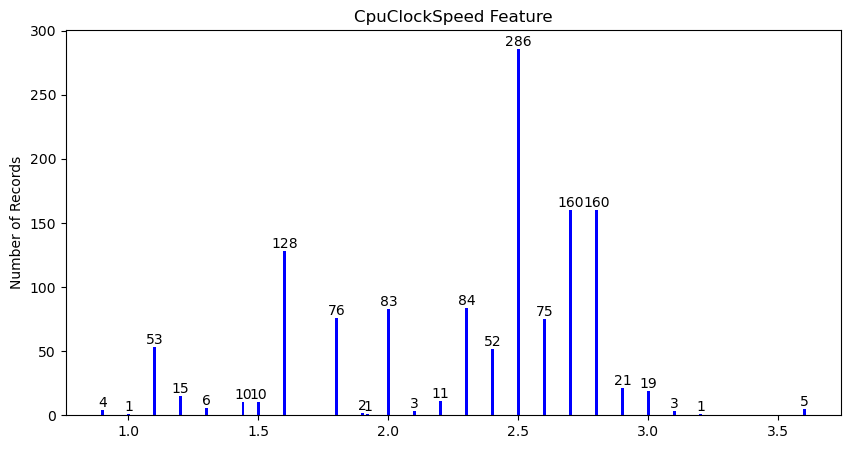

In [92]:
# Plotting the CpuClockSpeed feature frequencies
cpu_clockspeed_freq = df_notna['CpuClockSpeed'].value_counts()

plt.figure(figsize=(10,5))
bars = plt.bar(cpu_clockspeed_freq.index, cpu_clockspeed_freq.values, color=['b'], width = 0.01)
plt.title('CpuClockSpeed Feature')
plt.ylabel('Number of Records')

# Adding the values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    
plt.show()

In [93]:
# Drop the Cpu attribute after extracting all the information from it
df_notna = df_notna.drop(['Cpu'], axis = 1)

In [94]:
df_notna.Ram.unique()

array(['8GB', '16GB', '4GB', '2GB', '12GB', '64GB', '6GB', '32GB', '24GB',
       '1GB'], dtype=object)

In [95]:
# Remove the unit measure and convert to int
df_notna['Ram'] = df_notna['Ram'].str.replace('GB', '').astype(int)
df_notna.Ram.unique()

array([ 8, 16,  4,  2, 12, 64,  6, 32, 24,  1])

In [96]:
df_notna.Memory.unique()

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '128GB SSD +  1TB HDD', '256GB SSD +  256GB SSD',
       '64GB Flash Storage', '32GB Flash Storage', '256GB SSD +  1TB HDD',
       '256GB SSD +  2TB HDD', '32GB SSD', '2TB HDD', '64GB SSD',
       '1.0TB Hybrid', '512GB SSD +  1TB HDD', '1TB SSD',
       '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '?', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

In [97]:
# '?' tuples need to be addressed
df_notna.Memory.value_counts()

Memory
256GB SSD                        399
1TB HDD                          216
500GB HDD                        130
512GB SSD                        116
128GB SSD +  1TB HDD              92
128GB SSD                         74
256GB SSD +  1TB HDD              71
32GB Flash Storage                36
2TB HDD                           16
64GB Flash Storage                14
512GB SSD +  1TB HDD              14
1TB SSD                           13
256GB SSD +  2TB HDD              10
1.0TB Hybrid                       9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          4
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
128GB SSD +  2TB HDD               2
256GB SSD +  500GB HDD             2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD         

In [98]:
# Since there is only one '?' record, it is dropped
df_notna = df_notna[df_notna['Memory'] != '?']

In [99]:
# The Memory attribute is split in 2: HDD and SSD, initialized here
df_notna['SSD'] = 0
df_notna['HDD'] = 0

# Populate new attributes
for idx, row in df_notna.iterrows():
    memory_info = row['Memory']
    ssd_info = re.findall(r'(\d+)\s*(gb|tb)\s*(SSD|flash storage)', memory_info, re.I)
    hdd_info = re.findall(r'(\d+)\s*(gb|tb)\s*(HDD|hybrid)', memory_info, re.I)
    
    ssd_memory = sum(int(info[0]) * 1024 if info[1].lower() == 'tb' else int(info[0]) for info in ssd_info) if ssd_info else 0
    hdd_memory = sum(int(info[0]) * 1024 if info[1].lower() == 'tb' else int(info[0]) for info in hdd_info) if hdd_info else 0
    
    df_notna.at[idx, 'SSD'] = ssd_memory
    df_notna.at[idx, 'HDD'] = hdd_memory

In [100]:
# Drop old Memory attribute
df_notna = df_notna.drop(['Memory'], axis = 1)

In [101]:
df_notna['SSD'].unique()

array([ 128,  256,  512,    0,   64,   32, 1024,   16,  768,  180,  240,
          8], dtype=int64)

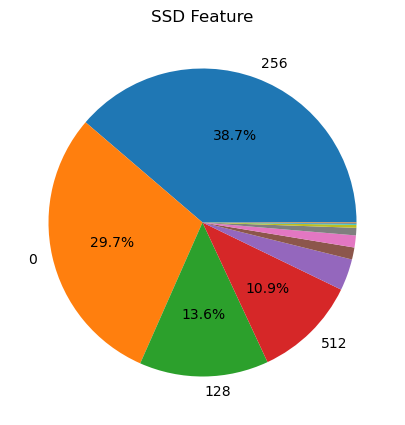

In [102]:
# Plotting the SSD feature frequencies
ssd_freq = df_notna['SSD'].value_counts()

# Calculate percentages
percentages = ssd_freq.values / ssd_freq.values.sum() * 100

# Create labels, but replace those under 4% with an empty string
labels = [f'{i}' if perc >= 4 else '' for i, perc in zip(ssd_freq.index, percentages)]

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct >= 4 else ''

plt.figure(figsize=(10,5))
plt.pie(ssd_freq.values, labels=labels, autopct=custom_autopct)
plt.title('SSD Feature')

plt.show()

In [103]:
df_notna.shape

(1268, 14)

In [104]:
df_notna['HDD'].unique()

array([   0,  500, 1024, 2048,   32,  128,  508], dtype=int64)

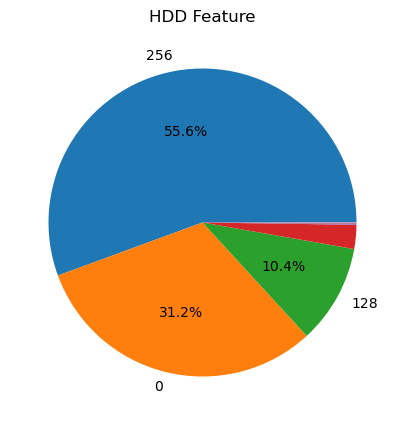

In [105]:
# Plotting the SSD feature frequencies
hdd_freq = df_notna['HDD'].value_counts()

# Calculate percentages
percentages = hdd_freq.values / hdd_freq.values.sum() * 100

# Create labels, but replace those under 4% with an empty string
labels = [f'{i}' if perc >= 4 else '' for i, perc in zip(ssd_freq.index, percentages)]

plt.figure(figsize=(10,5))
plt.pie(hdd_freq.values, labels=labels, autopct=custom_autopct)
plt.title('HDD Feature')

plt.show()

In [106]:
df_notna.Gpu.unique()

array(['Intel Iris Plus Graphics 640', 'Intel HD Graphics 6000',
       'Intel HD Graphics 620', 'AMD Radeon Pro 455',
       'Intel Iris Plus Graphics 650', 'AMD Radeon R5',
       'Intel Iris Pro Graphics', 'Nvidia GeForce MX150',
       'Intel UHD Graphics 620', 'Intel HD Graphics 520',
       'AMD Radeon Pro 555', 'AMD Radeon R5 M430',
       'Intel HD Graphics 615', 'AMD Radeon Pro 560',
       'Nvidia GeForce 940MX', 'Nvidia GeForce GTX 1050', 'AMD Radeon R2',
       'AMD Radeon 530', 'Nvidia GeForce 930MX', 'Intel HD Graphics',
       'Intel HD Graphics 500', 'Nvidia GeForce 930MX ',
       'Nvidia GeForce GTX 1060', 'Nvidia GeForce 150MX',
       'Intel Iris Graphics 540', 'AMD Radeon RX 580',
       'Nvidia GeForce 920MX', 'AMD Radeon R4 Graphics', 'AMD Radeon 520',
       'Nvidia GeForce GTX 1070', 'Nvidia GeForce GTX 1050 Ti',
       'Intel HD Graphics 400', 'Nvidia GeForce MX130', 'AMD R4 Graphics',
       'Nvidia GeForce GTX 940MX', 'AMD Radeon RX 560',
       'Nvidia GeFo

In [107]:
# Extract information about producer, model, series and make new attributes
def extract_gpu_info(gpu):
    words = gpu.split()
    producer = words[0]
    model = ' '.join(words[1:]) if len(words) > 1 else None
    return producer, model

df_notna[['GpuProducer', 'GpuModel']] = df_notna['Gpu'].apply(lambda x: pd.Series(extract_gpu_info(x)))

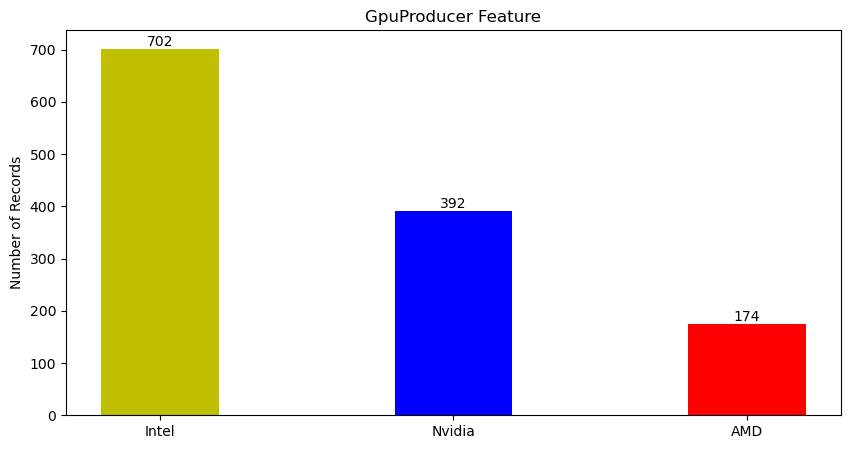

In [108]:
# Plotting the GpuProducer feature frequencies
gpu_producer_freq = df_notna['GpuProducer'].value_counts()

plt.figure(figsize=(10,5))
bars = plt.bar(gpu_producer_freq.index, gpu_producer_freq.values, color=['y', 'b', 'r'], width = 0.4)
plt.title('GpuProducer Feature')
plt.ylabel('Number of Records')

# Adding the values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    
plt.show()

In [109]:
# Drop Gpu attribute after extracting information from it
df_notna = df_notna.drop(['Gpu'], axis = 1)

In [110]:
pd.set_option('display.max_rows', 1000)
df_notna.GpuModel.value_counts()

GpuModel
HD Graphics 620            272
HD Graphics 520            181
UHD Graphics 620            65
GeForce GTX 1050            64
GeForce GTX 1060            48
GeForce 940MX               42
HD Graphics 500             39
Radeon 530                  38
HD Graphics 400             34
GeForce GTX 1070            29
HD Graphics                 29
GeForce GTX 1050 Ti         27
GeForce 930MX               25
Radeon R5 M430              22
GeForce 920MX               17
Radeon 520                  16
HD Graphics 515             15
GeForce MX150               15
HD Graphics 615             14
GeForce GTX 960M            14
Radeon R7 M445              13
HD Graphics 505             12
Radeon R5                   11
GeForce GTX 980M            10
HD Graphics 405              9
Quadro M1200                 8
Iris Plus Graphics 640       8
Radeon R5 M420               7
Radeon R5 M330               7
GeForce GTX 950M             7
GeForce GTX 1080             6
GeForce MX130                6

In [111]:
# Define a function to solve some inconsistencies
def replace_value(df, column, old_value, new_value):
    df[column] = df[column].replace(old_value, new_value)
    return df

In [112]:
# Solve inconsistencies
df_notna = replace_value(df_notna, 'GpuModel', 'GeForce GTX 960<U+039C>', 'GeForce GTX 960')
df_notna = replace_value(df_notna, 'GpuModel', 'Radeon R2', 'Radeon R2 Graphics')
df_notna = replace_value(df_notna, 'GpuModel', 'Radeon R4', 'Radeon R4 Graphics')
df_notna = replace_value(df_notna, 'GpuModel', 'R4 Graphics', 'Radeon R4 Graphics')
df_notna = replace_value(df_notna, 'GpuModel', 'Radeon R7', 'Radeon R7 Graphics')
df_notna = replace_value(df_notna, 'GpuModel', 'Radeon R4', 'Radeon R4 Graphics')
df_notna = replace_value(df_notna, 'GpuModel', 'Radeon R5', 'Radeon R5 Graphics')
df_notna = replace_value(df_notna, 'GpuModel', 'Radeon R4', 'Radeon R4 Graphics')

In [113]:
df_notna.GpuModel.unique()

array(['Iris Plus Graphics 640', 'HD Graphics 6000', 'HD Graphics 620',
       'Radeon Pro 455', 'Iris Plus Graphics 650', 'Radeon R5 Graphics',
       'Iris Pro Graphics', 'GeForce MX150', 'UHD Graphics 620',
       'HD Graphics 520', 'Radeon Pro 555', 'Radeon R5 M430',
       'HD Graphics 615', 'Radeon Pro 560', 'GeForce 940MX',
       'GeForce GTX 1050', 'Radeon R2 Graphics', 'Radeon 530',
       'GeForce 930MX', 'HD Graphics', 'HD Graphics 500',
       'GeForce GTX 1060', 'GeForce 150MX', 'Iris Graphics 540',
       'Radeon RX 580', 'GeForce 920MX', 'Radeon R4 Graphics',
       'Radeon 520', 'GeForce GTX 1070', 'GeForce GTX 1050 Ti',
       'HD Graphics 400', 'GeForce MX130', 'GeForce GTX 940MX',
       'Radeon RX 560', 'GeForce 920M', 'Radeon R7 M445', 'Radeon RX 550',
       'GeForce GTX 1050M', 'HD Graphics 515', 'Radeon R5 M420',
       'HD Graphics 505', 'GTX 980 SLI', 'R17M-M1-70', 'GeForce GTX 1080',
       'Quadro M1200', 'GeForce GTX 950M', 'FirePro W4190M',
       'GeForc

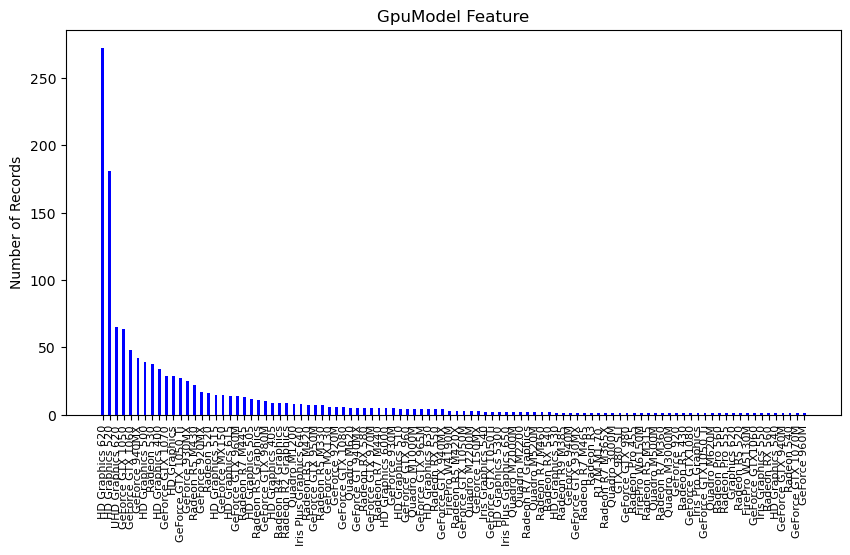

In [119]:
# Plotting the GpuModel feature frequencies
cpu_model_freq = df_notna['GpuModel'].value_counts()

plt.figure(figsize=(10,5))
bars = plt.bar(cpu_model_freq.index, cpu_model_freq.values, color=['b'], width = 0.4)
plt.title('GpuModel Feature')
plt.ylabel('Number of Records')
plt.xticks(rotation='vertical', fontsize = 8)
plt.show()

In [56]:
# Calculate mean encoding on this new DataFrame
mean_encode = df_notna.groupby('GpuModel')['Price'].mean().round(2)  

# Apply mean encoding to 'GpuModel' and rank the results obtained to avoid leakage
df_notna.loc[:, 'GpuModel'] = df_notna['GpuModel'].map(mean_encode)
sorted_gpu_models = sorted(df_notna['GpuModel'].unique())
gpu_model_ranks = {model: rank for rank, model in enumerate(sorted_gpu_models, 1)}
df_notna.loc[:, 'GpuModel'] = df_notna['GpuModel'].map(gpu_model_ranks)

In [238]:
df_notna.OpSys.value_counts()

OpSys
Windows 10      1043
No OS             63
Linux             61
Windows 7         45
Chrome OS         26
macOS             13
Mac OS X           8
Windows 10 S       8
Android            1
Name: count, dtype: int64

In [239]:
# The last 3 are rare, so they are merged with those of their kind
df_notna.loc[df_notna['OpSys'] == 'Mac OS X', 'OpSys'] = 'macOS'
df_notna.loc[df_notna['OpSys'] == 'Windows 10 S', 'OpSys'] = 'Windows 10'
df_notna.loc[df_notna['OpSys'] == 'Android', 'OpSys'] = 'Chrome OS'

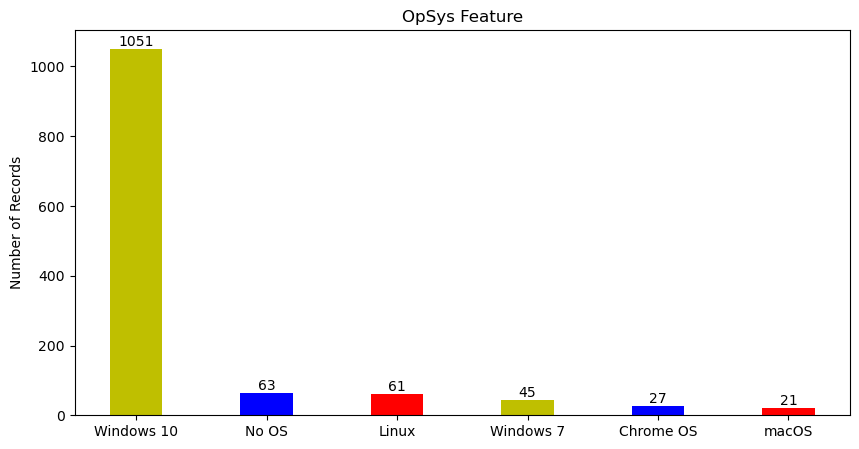

In [240]:
# Plotting the OpSys feature frequencies
opsys_freq = df_notna['OpSys'].value_counts()

plt.figure(figsize=(10,5))
bars = plt.bar(opsys_freq.index, opsys_freq.values, color=['y', 'b', 'r'], width = 0.4)
plt.title('OpSys Feature')
plt.ylabel('Number of Records')

# Adding the values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    
plt.show()

In [241]:
# Convert the currency from indian to dollars and truncate to second decimal
exchange_rate = 0.012
df_notna['Price'] = (df_notna['Price'] * exchange_rate).round(2)

In [242]:
# Extract min and max prices
min_value = df_notna['Price'].min()
max_value = df_notna['Price'].max()

print(f"Minimum: {min_value}, Maximum: {max_value}")

Minimum: 111.25, Maximum: 3899.46


In [243]:
df_notna

,Company,TypeName,Inches,ScreenResolution,Ram,OpSys,Weight,Price,CpuProducer,CpuModel,CpuClockSpeed,SSD,HDD,GpuProducer,GpuModel
0,Apple,Ultrabook,13.3,4096000,8,macOS,1.37,856.54,Intel,Core i5,2.3,128,0,Intel,69
1,Apple,Ultrabook,13.3,1296000,8,macOS,1.34,574.75,Intel,Core i5,1.8,128,0,Intel,37
2,HP,Notebook,15.6,2073600,8,No OS,1.86,367.63,Intel,Core i5,2.5,256,0,Intel,44
3,Apple,Ultrabook,15.4,5184000,16,macOS,1.83,1622.34,Intel,Core i7,2.7,512,0,AMD,84
4,Apple,Ultrabook,13.3,4096000,8,macOS,1.37,1153.15,Intel,Core i5,3.1,256,0,Intel,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,14,2073600,4,Windows 10,1.80,407.91,Intel,Core i7,2.5,128,0,Intel,40
1299,Lenovo,2 in 1 Convertible,13.3,5760000,16,Windows 10,1.30,958.40,Intel,Core i7,2.5,512,0,Intel,40
1300,Lenovo,Notebook,14,1049088,2,Windows 10,1.50,146.41,Intel,Celeron Dual Core,1.6,64,0,Intel,6
1301,HP,Notebook,15.6,1049088,6,Windows 10,2.19,488.47,Intel,Core i7,2.5,0,1024,AMD,25


In [244]:
# One-hot Encode categorical attributes with no order issues
df_notna = pd.get_dummies(df_notna, columns=['Company', 'TypeName', 'OpSys', 'CpuProducer', 'GpuProducer'])

In [245]:
# Convert boolean columns to binary
df_notna = df_notna.map(lambda x: int(x) if type(x) == bool else x)

In [246]:
df_notna

,Inches,ScreenResolution,Ram,Weight,Price,CpuModel,CpuClockSpeed,SSD,HDD,GpuModel,...,OpSys_Linux,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 7,OpSys_macOS,CpuProducer_AMD,CpuProducer_Intel,GpuProducer_AMD,GpuProducer_Intel,GpuProducer_Nvidia
0,13.3,4096000,8,1.37,856.54,Core i5,2.3,128,0,69,...,0,0,0,0,1,0,1,0,1,0
1,13.3,1296000,8,1.34,574.75,Core i5,1.8,128,0,37,...,0,0,0,0,1,0,1,0,1,0
2,15.6,2073600,8,1.86,367.63,Core i5,2.5,256,0,44,...,0,1,0,0,0,0,1,0,1,0
3,15.4,5184000,16,1.83,1622.34,Core i7,2.7,512,0,84,...,0,0,0,0,1,0,1,1,0,0
4,13.3,4096000,8,1.37,1153.15,Core i5,3.1,256,0,73,...,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,14,2073600,4,1.80,407.91,Core i7,2.5,128,0,40,...,0,0,1,0,0,0,1,0,1,0
1299,13.3,5760000,16,1.30,958.40,Core i7,2.5,512,0,40,...,0,0,1,0,0,0,1,0,1,0
1300,14,1049088,2,1.50,146.41,Celeron Dual Core,1.6,64,0,6,...,0,0,1,0,0,0,1,0,1,0
1301,15.6,1049088,6,2.19,488.47,Core i7,2.5,0,1024,25,...,0,0,1,0,0,0,1,1,0,0


In [247]:
# Now to encode the CpuModel according to the performance order
df_notna.CpuModel.unique()

# Define the order
cpu_order = ['Atom', 'Celeron Dual Core', 'A4-Series', 'A6-Series', 'E-Series',
             'Pentium Dual Core', 'Pentium Quad Core', 'A9-Series', 'Core M', 
             'Core i3', 'A8-Series', 'A10-Series', 'A12-Series', 'Core i5', 
             'Ryzen', 'Core i7', 'FX', 'Xeon']

# Create a dictionary that maps each CPU model to its rank
cpu_dict = {cpu: i for i, cpu in enumerate(cpu_order)}

# Replace the CPU models in the dataframe with their ranks
df_notna['CpuModel'] = df_notna['CpuModel'].map(cpu_dict)

In [248]:
# Now that the DataFrame is numeric, uniform the type
df_notna = df_notna.astype(float)

In [249]:
# Weight and Inches are likely correlated
df_notna['Weight'].corr(df_notna['Inches'])

0.49609210997696257

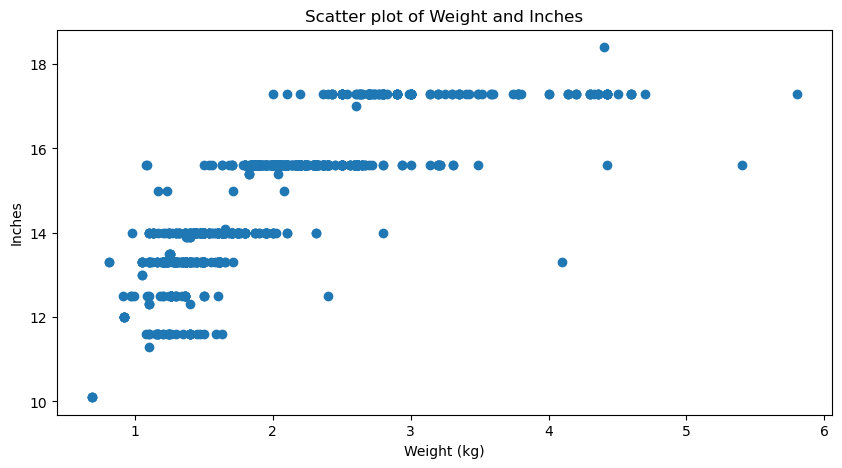

In [250]:
# Plotting scatter plot of 'Weight' and 'Inches'
df_filtered = df_notna[(df_notna['Weight'] < 6) & (df_notna['Inches'] < 20)]
plt.figure(figsize=(10,5))
plt.scatter(df_filtered['Weight'], df_filtered['Inches'])
plt.title('Scatter plot of Weight and Inches')
plt.xlabel('Weight (kg)')
plt.ylabel('Inches')
plt.show()

In [251]:
# Since Weight and Inches are correlated, use their product
df_notna['Weight_Inches'] = df_notna['Weight'] * df_notna['Inches']
df_notna = df_notna.drop('Weight', axis=1)
df_notna = df_notna.drop('Inches', axis=1)

In [252]:
# Drop remaining null values
df_notna = df_notna.dropna()

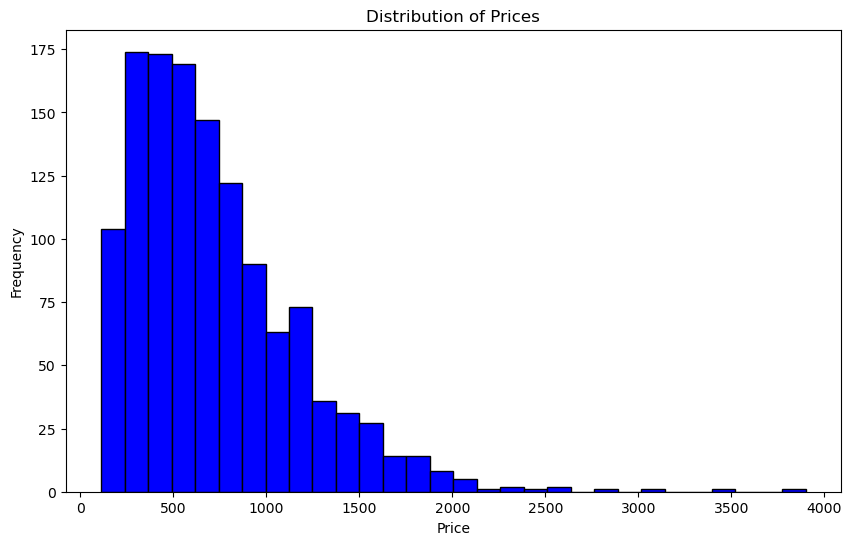

In [253]:
# Target variable
plt.figure(figsize=(10,6))
plt.hist(df_notna['Price'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [254]:
# Counting records before oversampling
count_before = len(laptop_df)

In [255]:
# Synthetic sampling of high price laptops because of imbalance
max_attempts = 5

for attempt in range(max_attempts):
    try:
        # Synthetic sampling of high price laptops because of imbalance
        df_notna = smogn.smoter(
            data = df_notna, 
            y = 'Price',
            k = 5,                   
            samp_method = 'extreme',  
            rel_xtrm_type = 'high',
            drop_na_col = True,       
            drop_na_row = True,       
            replace = False)

        # If the sampling is successful, break the loop
        break

    except ValueError as e:
        print(f"Attempt {attempt+1} of {max_attempts} failed with error: {e}")
        print("Retrying...")
        
        time.sleep(1)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        break


r_index: 100%|########################################################################| 83/83 [00:00<00:00, 418.00it/s]


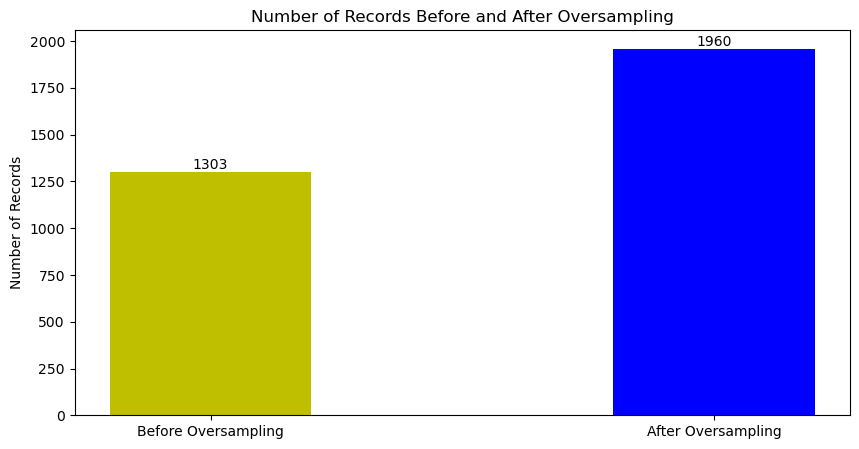

In [256]:
# Plotting the number of records before and after oversampling
count_after = len(df_notna)

# Plotting histogram of record counts
plt.figure(figsize=(10,5))
bars = plt.bar(['Before Oversampling', 'After Oversampling'], [count_before, count_after], color=['y', 'b'], width = 0.4)
plt.title('Number of Records Before and After Oversampling')
plt.ylabel('Number of Records')

# Adding the values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    
plt.show()

In [257]:
# Apply logarithm to reduce the impact of high prices
df_notna['Price'] = np.log(df_notna['Price'])

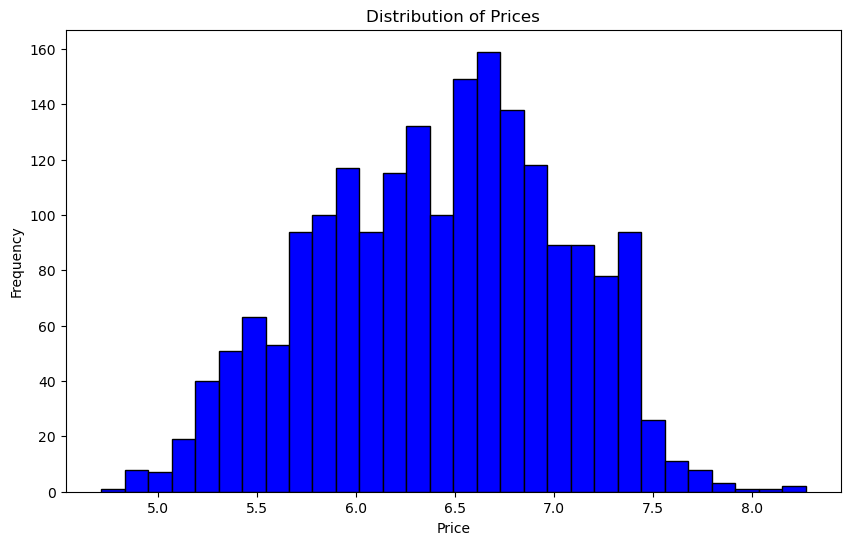

In [258]:
# After the log
plt.figure(figsize=(10,6))
plt.hist(df_notna['Price'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Feature Selection

In [259]:
# Separate the target variable from the training set and scale it
X_train = df_notna.drop('Price', axis=1)
y_train = np.ravel(RobustScaler().fit_transform(df_notna['Price'].values.reshape(-1, 1)))

In [260]:
# Set the number of folds for the cross validations in grid searches
hp_folds = 5

In [261]:
# Grid search to tune the hyperparameters of the model for feature selection
model = RandomForestRegressor()

# Define the parameters grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=hp_folds, 
                           scoring='neg_mean_squared_error', 
                           verbose=1, n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print(f'Best parameters: {best_parameters}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


CpuModel                       0.475432
Ram                            0.184549
GpuModel                       0.104160
TypeName_Notebook              0.072317
Weight_Inches                  0.044263
SSD                            0.032312
CpuClockSpeed                  0.016288
ScreenResolution               0.008850
Company_HP                     0.008847
OpSys_No OS                    0.005781
OpSys_Windows 10               0.004595
Company_Asus                   0.003899
TypeName_Ultrabook             0.003803
Company_Acer                   0.003772
GpuProducer_Intel              0.003613
TypeName_2 in 1 Convertible    0.003611
Company_Lenovo                 0.003591
Company_Dell                   0.002986
HDD                            0.002855
OpSys_Windows 7                0.002371
Company_Razer                  0.002068
TypeName_Gaming                0.001771
GpuProducer_Nvidia             0.001508
OpSys_Linux                    0.001204
Company_Vero                   0.001114


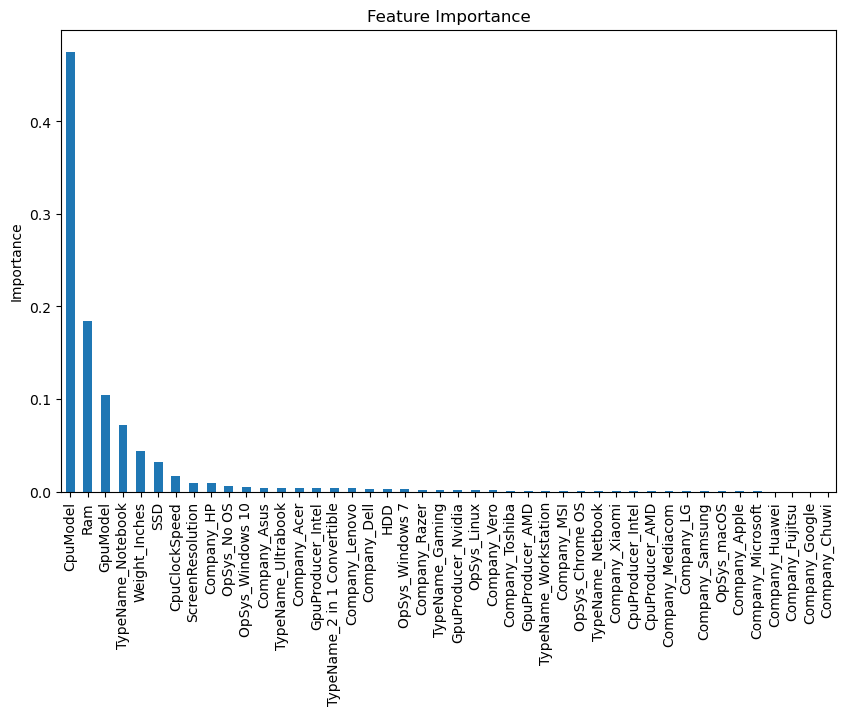

In [262]:
# Create a new model with the best parameters
model = grid_search.best_estimator_

# Fit the model to compute the feature importances
model.fit(X_train, y_train)

# Get the feature importances
importances = model.feature_importances_

# Get the names of the features from the DataFrame
feature_names = X_train.columns

# Create a Series with the feature importances, sort it in descending order
importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Print the feature importances
print(importance_series)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importance_series.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.show()

In [263]:
# Features whose importance is over a threshold
important_features_mask = importances >= 0.001
best_n_features = important_features_mask.sum()

# Tuned model for feature selection
model = grid_search.best_estimator_

# Fit to the training data
rfe = RFE(estimator = model, n_features_to_select = best_n_features)

# Models Training and Evaluation Setup

In [264]:
# These custom functions are necessary to convert back prices from log transformation during evaluation
def custom_mae(y_true, y_pred):
    y_pred_orig = np.exp(y_pred)
    y_true_orig = np.exp(y_true)
    return mean_absolute_error(y_true_orig, y_pred_orig)

def custom_r2(y_true, y_pred):
    y_pred_orig = np.exp(y_pred)
    y_true_orig = np.exp(y_true)
    return r2_score(y_true_orig, y_pred_orig)

scoring = {'neg_mean_absolute_error': make_scorer(custom_mae, greater_is_better=False),
           'r2': make_scorer(custom_r2)}

# Initialize a list of models
models = []

# Linear Regression Model

In [265]:
model_lr = LinearRegression()

# Building a pipeline
estimators = [('scaling', RobustScaler()), ('feature-selection', rfe), 
              ('clf', model_lr)]
pipe_lr = Pipeline(estimators)

models.append(pipe_lr)

# Random Forest Model

In [266]:
# Grid search for hyperparameters tuning
model = RandomForestRegressor()

# Define the parameters grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=hp_folds, 
                           scoring=make_scorer(mean_absolute_error, 
                                       greater_is_better=False), 
                           verbose=1, n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print(f'Best parameters: {best_parameters}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [267]:
model_rf = grid_search.best_estimator_

# Building a pipeline
estimators = [('scaling', RobustScaler()),
              ('feature-selection', rfe), ('clf', model_rf)]
pipe_rf = Pipeline(estimators)

models.append(pipe_rf)

# K-Nearest Neighbours Model

In [268]:
# Initialize the K-Nearest Neighbours Regressor
model = KNeighborsRegressor()

# Define the parameters grid
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=hp_folds, 
                           scoring=make_scorer(mean_absolute_error, 
                                       greater_is_better=False), 
                           verbose=1, n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print(f'Best parameters: {best_parameters}')


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [269]:
model_knn = grid_search.best_estimator_

# Building a pipeline
estimators = [('scaling', RobustScaler()),
              ('feature-selection', rfe), ('clf', model_knn)]
pipe_knn = Pipeline(estimators)

models.append(pipe_knn)

# Decision Tree Model

In [270]:
# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor()

# Define the parameters grid
param_grid = {
    'criterion': ['absolute_error', 'friedman_mse', 'squared_error'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=hp_folds, 
                           scoring=make_scorer(mean_absolute_error, 
                           greater_is_better=False), 
                           verbose=1, n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print(f'Best parameters: {best_parameters}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 20, 'min_samples_split': 10}


In [271]:
model_dt = grid_search.best_estimator_

# Building a pipeline
estimators = [('scaling', RobustScaler()),
              ('feature-selection', rfe), ('clf', model_dt)]
pipe_dt = Pipeline(estimators)

models.append(pipe_dt)

# AdaBoost Model

In [272]:
# Initialize the AdaBoost Regressor
model = AdaBoostRegressor()

# Define the parameters grid
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=hp_folds, 
                           scoring=make_scorer(mean_absolute_error, 
                                       greater_is_better=False),
                           verbose=1, n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print(f'Best parameters: {best_parameters}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 1500}


In [273]:
model_ada = grid_search.best_estimator_

# Building a pipeline
estimators = [('scaling', RobustScaler()),
              ('feature-selection', rfe), ('clf', model_ada)]
pipe_ada = Pipeline(estimators)

models.append(pipe_ada)

# Gradient Boosting Model

In [274]:
# Initialize the Gradient Boost Regressor
model = GradientBoostingRegressor()

# Define the parameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=hp_folds, 
                           scoring=make_scorer(mean_absolute_error, 
                           greater_is_better=False), 
                           verbose=1, n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print(f'Best parameters: {best_parameters}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


In [275]:
model_gb = grid_search.best_estimator_

# Building a pipeline
estimators = [('scaling', RobustScaler()), 
              ('feature-selection', rfe), ('clf', model_gb)]
pipe_gb = Pipeline(estimators)

models.append(pipe_gb)

# Training and Cross Validation 

In [276]:
# Lists to store scores
scores_all_models_mae = []
scores_all_models_r2 = []

# Lists to store averages over the 10 folds
mean_scores_all_models_mae = []
mean_scores_all_models_r2 = []


# Create a KFold object with a fixed random state to train on the same folds and be able to apply statistical tests
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Loop to train and evaluate models
for model in models:
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring = scoring)
    
    # Scores stored
    scores_all_models_mae.append(scores['test_neg_mean_absolute_error'])
    scores_all_models_r2.append(scores['test_r2'])
    
    # Mean scores stored
    mean_scores_all_models_mae.append(np.mean(scores['test_neg_mean_absolute_error']))
    mean_scores_all_models_r2.append(np.mean(scores['test_r2']))

# Results and Comparison

In [277]:
# Average evaluation metrics for the 10 folds of each model
model_names = ['Linear Regression', 'Random Forest', 'K-Nearest Neighbours', 'Decision Tree', 'AdaBoost', 'Gradient Boosting']

print("Model Performance:")
for i in range(len(models)):
    print("\n" + model_names[i] + ":")
    print("Mean MAE: ", -mean_scores_all_models_mae[i])
    print("Mean R2: ", mean_scores_all_models_r2[i])

Model Performance:

Linear Regression:
Mean MAE:  0.23108786228388664
Mean R2:  0.7956515734561769

Random Forest:
Mean MAE:  0.1571779099864062
Mean R2:  0.8869266121619397

K-Nearest Neighbours:
Mean MAE:  0.17232517797606922
Mean R2:  0.8634276045397271

Decision Tree:
Mean MAE:  0.21023937691152933
Mean R2:  0.7916578857409993

AdaBoost:
Mean MAE:  0.23559313019559233
Mean R2:  0.7809192193024306

Gradient Boosting:
Mean MAE:  0.14771994266609728
Mean R2:  0.9011106927079522


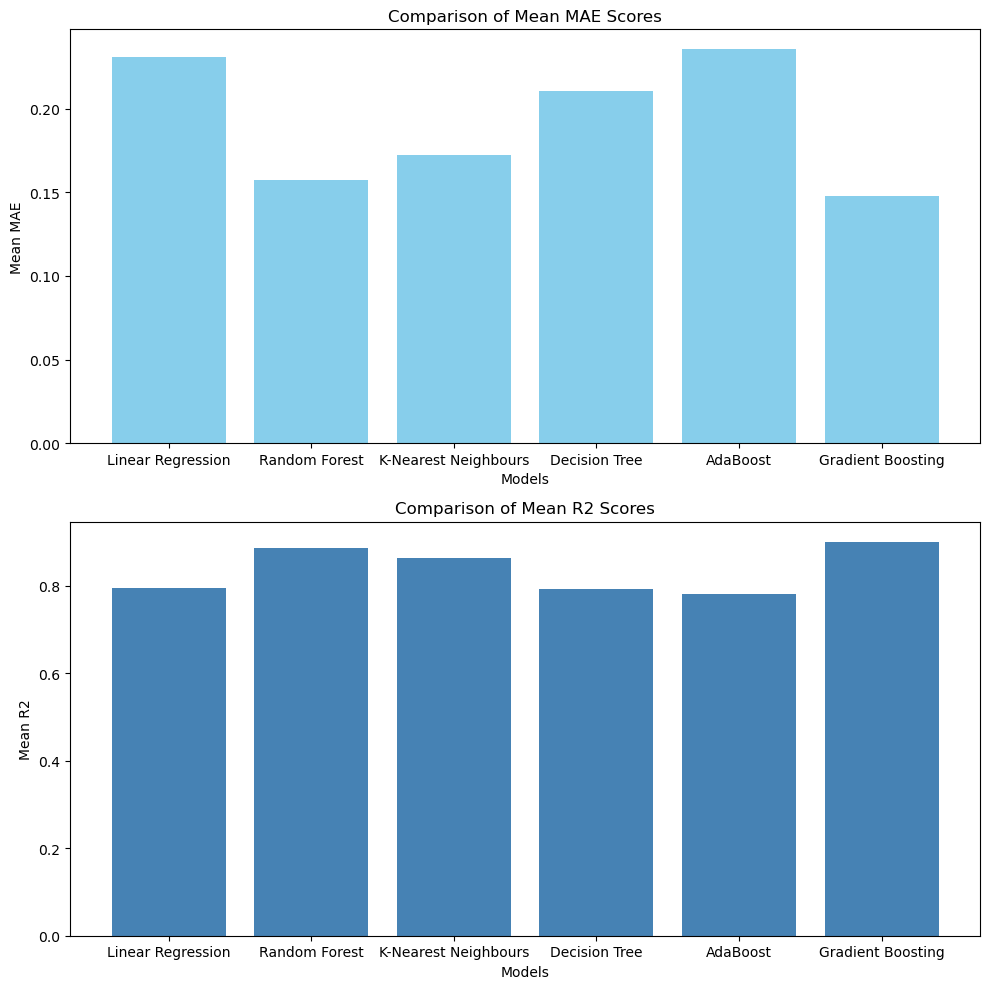

In [280]:
# Convert scores to positive values for plotting
positive_mae_scores = [-score for score in mean_scores_all_models_mae]

# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot Mean MAE scores
ax[0].bar(model_names, positive_mae_scores, color='skyblue')
ax[0].set_title('Comparison of Mean MAE Scores')
ax[0].set_ylabel('Mean MAE')
ax[0].set_xlabel('Models')

# Plot Mean R2 scores
ax[1].bar(model_names, mean_scores_all_models_r2, color='steelblue')
ax[1].set_title('Comparison of Mean R2 Scores')
ax[1].set_ylabel('Mean R2')
ax[1].set_xlabel('Models')

# Improve layout
plt.tight_layout()
plt.show()

In [289]:
# Wilcoxon test for mae on K-Nearest Neighbours and Random Forest models
print('Test: ', wilcoxon(scores_all_models_mae[1], scores_all_models_mae[2]))

Test:  WilcoxonResult(statistic=6.0, pvalue=0.02734375)


In [296]:
# Wilcoxon test for mae on K-Nearest Neighbours and Gradient Boosting models
print('Test: ', wilcoxon(scores_all_models_mae[2], scores_all_models_mae[5]))

Test:  WilcoxonResult(statistic=2.0, pvalue=0.005859375)


In [297]:
# Wilcoxon test for mae on Random Forest and Gradient Boosting models
print('Test: ', wilcoxon(scores_all_models_mae[1], scores_all_models_mae[5]))

Test:  WilcoxonResult(statistic=2.0, pvalue=0.005859375)


In [295]:
# Wilcoxon test for r2 on K-Nearest Neighbours and Random Forest models
print('Test: ', wilcoxon(scores_all_models_r2[1], scores_all_models_r2[2]))

Test:  WilcoxonResult(statistic=11.0, pvalue=0.10546875)


In [293]:
# Wilcoxon test for r2 on K-Nearest Neighbours and Gradient Boosting models
print('Test: ', wilcoxon(scores_all_models_r2[2], scores_all_models_r2[5]))

Test:  WilcoxonResult(statistic=5.0, pvalue=0.01953125)


In [292]:
# Wilcoxon test for r2 on Random Forest and Gradient Boosting models
print('Test: ', wilcoxon(scores_all_models_r2[1], scores_all_models_r2[5]))

Test:  WilcoxonResult(statistic=1.0, pvalue=0.00390625)
